## Exploration

train.csv shape is  (555719, 23)
test.csv shape is  (69465, 2)

       Id trans_date_trans_time        cc_num  \
0  205743      01/09/2020 08:22  5.596350e+15   
1  465349      12/12/2020 07:42  4.311370e+18   
2   17312      27/06/2020 13:03  2.264940e+15   
3  234968      14/09/2020 04:12  2.224100e+15   
4  194255      28/08/2020 17:40  3.527540e+15   

                              merchant       category      amt    first  \
0                      fraud_Berge LLC  gas_transport    72.18   Joseph   
1  fraud_Eichmann, Bogan and Rodriguez  gas_transport    36.66  Phillip   
2              fraud_Ankunding-Carroll         travel     1.74     Juan   
3     fraud_Schumm, Bauch and Ondricka    grocery_pos   140.99    Sheri   
4                    fraud_Gerlach Inc   shopping_net  1722.19   Teresa   

       last gender                        street  ...      lat      long  \
0     Moody      M              5901 Foster Pine  ...  29.9912  -90.2479   
1  Delacruz      M     26678 Lisa Lock

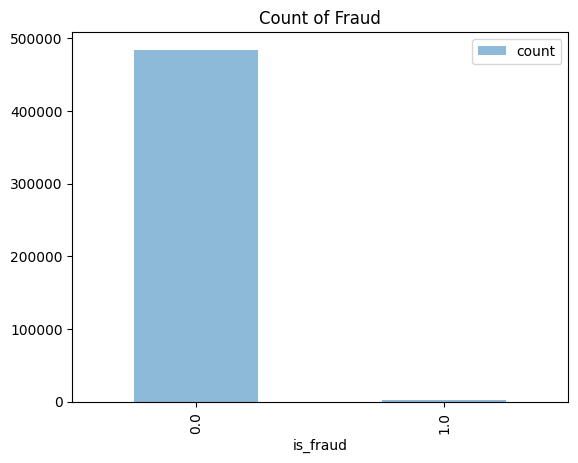

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['is_fraud'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Fraud")
plt.show()

                  Id        cc_num            amt            zip  \
count  555719.000000  5.557190e+05  555719.000000  555719.000000   
mean   277859.000000  4.178387e+17      69.392810   48842.628015   
std    160422.401459  1.309837e+18     156.745941   26855.283328   
min         0.000000  6.041621e+10       1.000000    1257.000000   
25%    138929.500000  1.800430e+14       9.630000   26292.000000   
50%    277859.000000  3.521420e+15      47.290000   48174.000000   
75%    416788.500000  4.635330e+15      83.010000   72011.000000   
max    555718.000000  4.992350e+18   22768.110000   99921.000000   

                 lat           long      city_pop     unix_time  \
count  555719.000000  555719.000000  5.557190e+05  5.557190e+05   
mean       38.543253     -90.231325  8.822189e+04  1.380679e+09   
std         5.061336      13.721780  3.003909e+05  5.201104e+06   
min        20.027100    -165.672300  2.300000e+01  1.371817e+09   
25%        34.668900     -96.798000  7.410000e+02  1

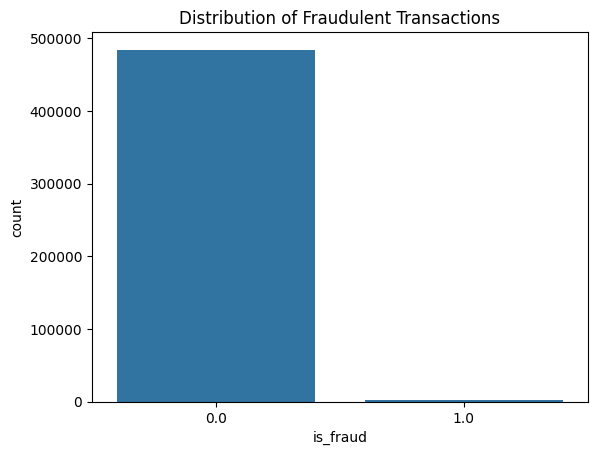

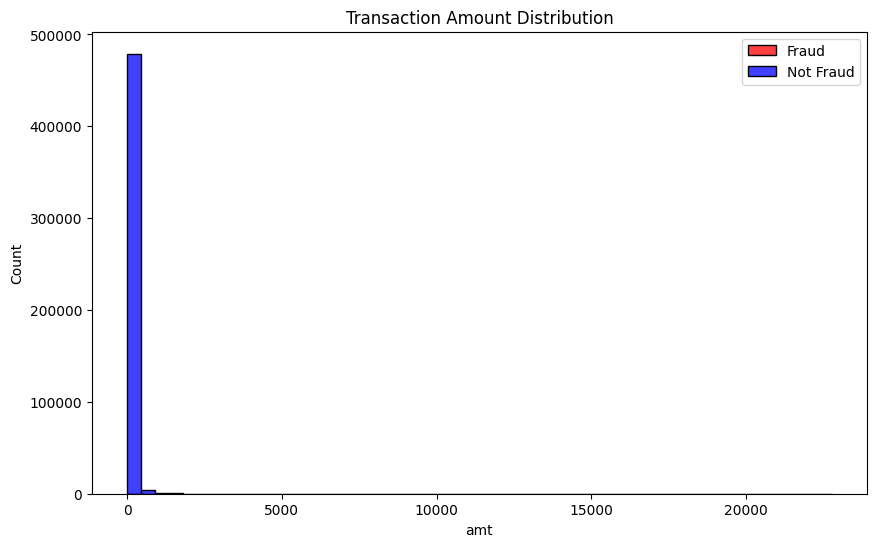

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
# Basic statistics of numerical features
print(train_df.describe())

# Count of fraudulent vs. non-fraudulent transactions
sns.countplot(x='is_fraud', data=train_df)
plt.title('Distribution of Fraudulent Transactions')
plt.show()

# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(train_df[train_df['is_fraud'] == 1]['amt'], bins=50, color='red', label='Fraud')
sns.histplot(train_df[train_df['is_fraud'] == 0]['amt'], bins=50, color='blue', label='Not Fraud')
plt.legend()
plt.title('Transaction Amount Distribution')
plt.show()


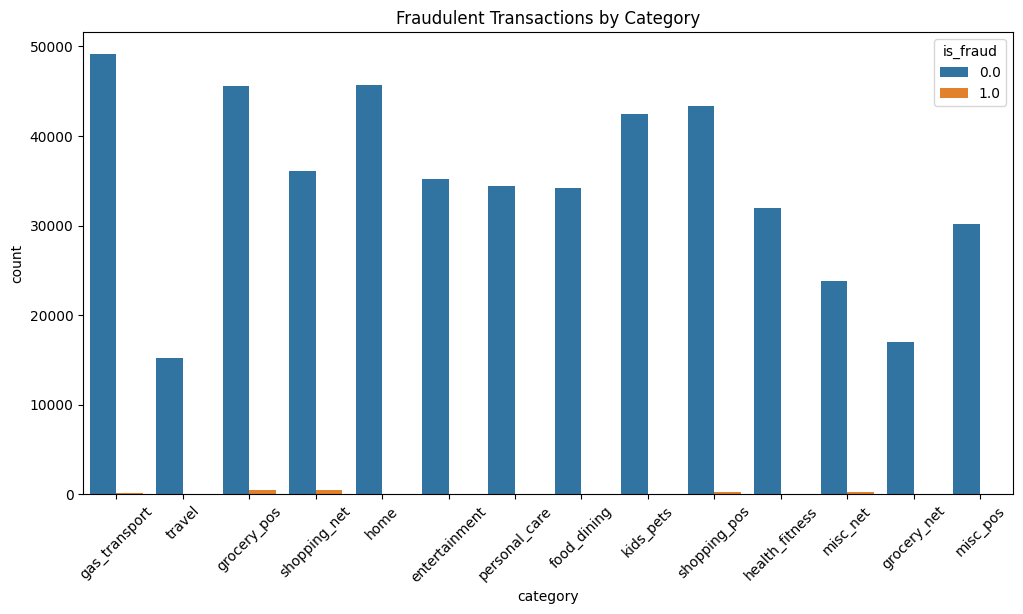

In [4]:
# Analyzing fraud distribution across categories
plt.figure(figsize=(12, 6))
sns.countplot(x='category', hue='is_fraud', data=train_df)
plt.title('Fraudulent Transactions by Category')
plt.xticks(rotation=45)
plt.show()


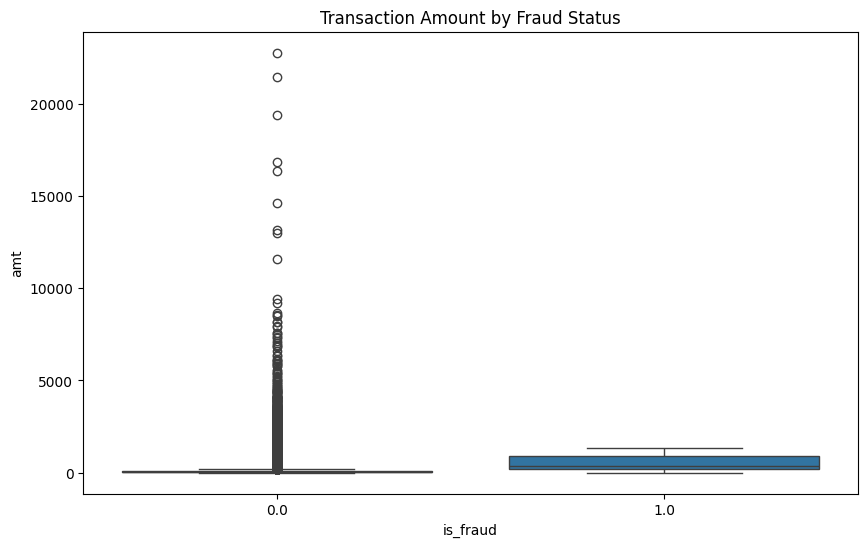

In [6]:
# High-value transactions and fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=train_df)
plt.title('Transaction Amount by Fraud Status')
plt.show()

# Investigate patterns in user behavior
# Note: Further analysis would involve aggregating transactions by user and examining patterns


## Feature Extraction

In [30]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Function to calculate the Haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Distance in kilometers
    distance = R * c
    return distance


def process(df):
    date_time = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
    birth_date = pd.to_datetime(df['dob'], format='%d/%m/%Y')

    df['trans_date'] = date_time.dt.date
    df['trans_time'] = date_time.dt.time
    df['trans_day_of_week'] = date_time.dt.dayofweek
    
    df['age'] = (date_time - birth_date).dt.days // 365
    df['trans_dist'] = haversine_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

    df.drop(columns=['trans_date_trans_time', 'lat', 'long', 'merch_lat', 'merch_long'], inplace=True)

    # Identifying categorical columns
    categorical_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']

    mappings = {}

    label_encoder = LabelEncoder()
    for col in categorical_cols:
        df[col] = label_encoder.fit_transform(df[col])
        mappings[col] = {label: index for index, label in enumerate(label_encoder.classes_)}

    return df, mappings

trainingSet = pd.read_csv("./data/train.csv")
submissionSet = pd.read_csv("./data/test.csv")
train_processed, cat_map = process(trainingSet)
train_processed.drop(columns=['cc_num', 'first', 'last', 'street', 'dob'], inplace=True)

# Merge on Id so that the test set can have feature columns as well
test_df= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
test_df = test_df.drop(columns=['is_fraud_x'])
test_df = test_df.rename(columns={'is_fraud_y': 'is_fraud'})

# The training set is where the score is not null
train_df = train_processed[train_processed['is_fraud'].notnull()]

# Save the datasets with the new features for easy access later
test_df.to_csv("./data/test_prepared.csv", index=False)
train_df.to_csv("./data/train_prepared.csv", index=False)



In [31]:
print(train_df.head())
print(test_df.head())
print(cat_map)

       Id  merchant  category      amt  gender  city  state    zip  city_pop  \
0  205743        43         2    72.18       1   380     17  70062     68211   
1  465349       153         2    36.66       1   354      5  80736       648   
2   17312         9        13     1.74       1   684     42  78214   1595797   
3  234968       572         4   140.99       0   385      9  31547      1293   
4  194255       189        11  1722.19       0   102     39  29911      1725   

   job                         trans_num   unix_time  is_fraud  trans_date  \
0  163  5223f3d810e0083482e47a5c3a1eba94  1378023768       0.0  2020-09-01   
1   92  25f3a9b8613a9745c5802031bd3a2c62  1386834132       0.0  2020-12-12   
2  248  2a6f3f7c697bc721a80078aefd68d857  1372338223       0.0  2020-06-27   
3  296  fcd03eb50b00fe682d8a47f3bec089a6  1379131971       0.0  2020-09-14   
4  410  d3105e269285b69b334e99433d6a6585  1377711655       0.0  2020-08-28   

  trans_time  trans_day_of_week  age  trans_dist  

In [4]:
print(800 // 365)

2


## Creating your model

Index(['Id', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long'],
      dtype='object')
Accuracy on testing set =  0.9954674081142444
F1 score on testing set =  0.44174265450861194


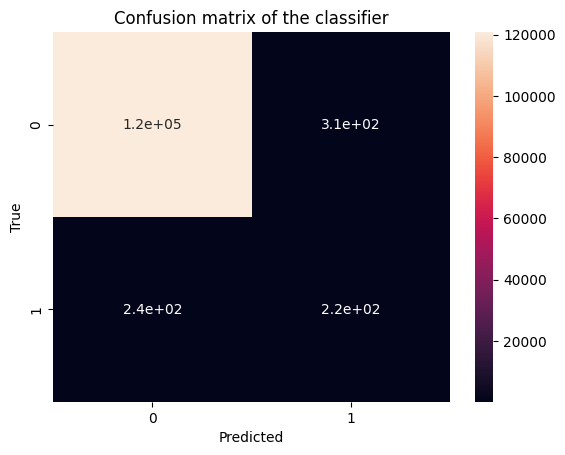

In [3]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['is_fraud'], axis=1),
        X_train['is_fraud'],
        test_size=1/4.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed = X_train._get_numeric_data()
print(X_train_processed.columns)
X_test_processed = X_test._get_numeric_data()

# Learn the model
model = DecisionTreeClassifier().fit(X_train_processed, Y_train)

# pickle model - saves it so you can load it later
with open('knn_20_model.obj', 'wb') as f:
        pickle.dump(model, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
#    model = pickle.load(f)

# Evaluate your model on the testing set
Y_test_predictions = model.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("F1 score on testing set = ", f1_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Create the Kaggle submission

In [4]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission._get_numeric_data().drop(columns=['is_fraud'])
print(X_submission_processed.columns)

X_submission['is_fraud'] = model.predict(X_submission_processed)
X_submission.is_fraud = X_submission.is_fraud.astype(int)
submission = X_submission[['Id', 'is_fraud']]
submission.to_csv("./data/submission.csv", index=False)

Index(['Id', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long'],
      dtype='object')


Now you can upload the `submission.csv` to kaggle